In [9]:
# Bayesian Binary logistic regression in 2d for iris flwoers

# Code is based on
# https://github.com/aloctavodia/BAP/blob/master/code/Chp4/04_Generalizing_linear_models.ipynb

%env MKL_THREADING_LAYER=GNU

try:
    import pymc as pm
except ModuleNotFoundError:
    %pip install mkl-service
    %pip install -qq pymc
    import pymc as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

try:
    import arviz as az
except ModuleNotFoundError:
    %pip install -qq arviz
    import arviz as az
from sklearn.datasets import load_iris

try:
    from probml_utils import savefig, latexify, is_latexify_enabled
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils import savefig, latexify, is_latexify_enabled

env: MKL_THREADING_LAYER=GNU


In [2]:
latexify(width_scale_factor=2, fig_height=1.75)

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


In [3]:
iris = load_iris()
X = iris.data
y = iris.target

# Convert to pandas dataframe
df_iris = pd.DataFrame(data=iris.data, columns=["sepal_length", "sepal_width", "petal_length", "petal_width"])
df_iris["species"] = pd.Series(iris.target_names[y], dtype="category")

df = df_iris.query("species == ('setosa', 'versicolor')")

In [4]:
# We reduce the sample size from 50 to 25 per class,
# or to 5 + 45 in the unbalanced setting.
# The latter will increase posterior uncertainty

def create_classes(df,unbalanced):
  if unbalanced:
    df1 = df[45:95]
  else:
    df1 = df[25:75]
  assert len(df1) == 50
  y_1 = pd.Categorical(df1["species"]).codes
  x_n = ["sepal_length", "sepal_width"]
  x_1 = df1[x_n].values
  return x_1,y_1

In [5]:
def decision_boundary(x_1,y_1):
  with pm.Model() as model_1:
      α = pm.Normal("α", mu=0, sigma=10)
      β = pm.Normal("β", mu=0, sigma=2, shape=2)

      μ = α + pm.math.dot(x_1, β)
      bd = pm.Deterministic("bd", -α / β[1] - β[0] / β[1] * x_1[:, 0])

      yl = pm.Bernoulli("yl", logit_p=μ, observed=y_1)

      idata = pm.sample(2000, cores=1, chains=2)
      return idata

In [6]:
def plot_fig(idata,unbalanced,x_1,y_1):
  bdsamples=np.array(idata['posterior']['bd'])
  bdsamplesflatten = bdsamples.reshape(-1, bdsamples.shape[-1])
  idx = np.argsort(x_1[:, 0])
  bd=bdsamplesflatten.mean(0)[idx]
  plt.figure()
  plt.scatter(x_1[:, 0], x_1[:, 1], c=[f"C{x}" for x in y_1],s=10)
  sns.despine()
  plt.ylim([0,7])
  plt.plot(x_1[:, 0][idx], bd, color="k")

  az.plot_hdi(x_1[:, 0], bdsamplesflatten, color="k")

  plt.xlabel("sepal length")
  plt.ylabel("sepal width")
  plt.tight_layout()
  if unbalanced:
    savefig("logreg_iris_bayes_2d_unbalanced")
  else:
    savefig("logreg_iris_bayes_2d")
  plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [α, β]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 30 seconds.
/usr/local/lib/python3.7/dist-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


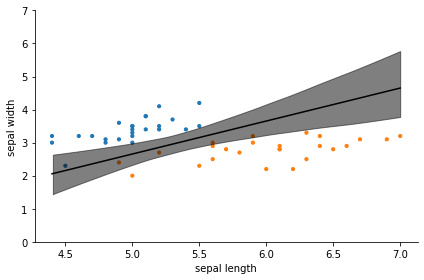

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [α, β]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 24 seconds.
/usr/local/lib/python3.7/dist-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


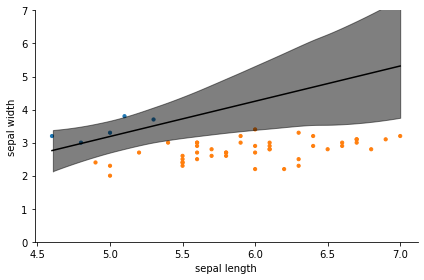

In [10]:
for b in (False,True):
  x_1,y_1=create_classes(df,b)
  idata=decision_boundary(x_1,y_1)
  plot_fig(idata,b,x_1,y_1)